<a href="https://colab.research.google.com/github/good0neighbour/ESTCampAI/blob/main/%EC%96%B8%EC%96%B4%EC%A7%80%EB%8A%A5(%ED%97%88%EA%B9%85%ED%8E%98%EC%9D%B4%EC%8A%A4_NLP)/ex03_HuggingFace_Model_Finetuning(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# T4 gpu
# 드라이브 연동
# 작업 경로 언어지능 폴더 이동
%cd /content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)

/content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)


In [2]:
# transformers[torch] 라이브러리 설치
!pip install transformers[torch]

In [3]:
!pip show transformers

Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


## 목표
- 한국어 분류 데이터셋을 활용한 한국어 토픽 분류 모델 구현해보기
- 데이터 준비부터 미세조정(파인튜닝) 훈련까지의 흐름을 경험해보자
- 모델과 토크나이저, finetuning에 필요한 클래스를 직접 조작하며, 허깅페이스 내부 동작에 대해 조금 더 깊이 있는 실습을 진행

In [4]:
# gpu 장치 연결 확인
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print('사용 가능한 장치:', device)

# 추후 Trainer 클래스 사용할 예정

사용 가능한 장치: cuda


## 시나리오

### 배경
- “스마트뉴스”는 <u>월간 **12만 건** 이상의 뉴스 헤드라인</u>을 처리하는 AI 기반 토픽 분류 플랫폼  
- YNAT 데이터셋(연합뉴스 헤드라인, 7개 주제)으로 학습된 일반 사전학습 모델은 <u>**도메인별 뉘앙스**</u>와 <u>**언론사별 어투**</u>를 구분하기 어려움  
- <u>**Fine-Tuning**</u>을 통해 KoELECTRA 기반 분류 모델을 <u>**IT·과학, 경제, 사회 등 7개 주제**</u>에 최적화해야 하는 과제 존재  

```python
# 주요 이해관계자
- NLP 연구팀         : 사전학습 모델 파인튜닝 및 하이퍼파라미터 튜닝  
- 데이터 엔지니어팀   : YNAT 데이터 로딩·전처리·토크나이저 적용 파이프라인 구축  
- 제품 기획팀         : 토픽 분류 서비스 요구사항 정의 및 결과 활용 방안 수립  
- DevOps/운영팀      : T4 GPU 환경에서 모델 학습·배포·모니터링 자동화  
- QA/테스트팀        : 분류 정확도 검증 및 혼동행렬 기반 개선 포인트 제안  
```

## 1. 데이터셋 로드
- Hugging Face datasets 활용 데이터 로드 해보기

In [5]:
# huggingface 데이터셋 로드 함수 불러오기
from datasets import load_dataset

> **YNAT 데이터셋**  
> - 연합뉴스(Yonhap News) 기사 제목(헤드라인)을 **7개 주제**로 분류  
> - 레이블 0 ~ 6 : `정치` / `경제` / `사회` / `생활·문화` / `세계` / `IT·과학` / `스포츠`
> - HuggingFace 링크 : https://huggingface.co/datasets/klue/klue#considerations-for-using-the-data

---

```python
> 원출처 : KLUE Benchmark 프로젝트
> - "Korean Language Understanding Evaluation"의 약자  
> - 한국어 자연어 이해(NLU) 전용 종합 벤치마크로 설계  
> - 기계 번역·문장 분류·개체명 인식·관계 추출 등 8개 태스크 포함

> 논문
> - "KLUE: Korean Language Understanding Evaluation"  
> - EMNLP 2021 학회 게재  
> - 한국어 특화 NLU 모델 평가를 위한 표준 데이터셋 및 메트릭 제안

> 대규모 한국어 토픽 분류 데이터 제공 목적  
> - 한국어 NLU 모델의 토픽 분류 성능을 객관적으로 비교·평가  
> - 연구자들이 일관된 지표로 모델 개선 효과를 검증할 수 있도록 지원
```

In [6]:
# 연합뉴스 기사 제목 데이터셋 로드
# 간단히 내장된 klue 스크립트 활용 가능
raw_datasets = load_dataset("klue", "ynat")
# load_dataset("데이터셋_이름", "설정명(config, subset)", split = 'train')
# load_dataset("데이터셋_이름")
# load_dataset("데이터셋_이름", "설정명(config, subset)")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

ynat/train-00000-of-00001.parquet:   0%|          | 0.00/4.17M [00:00<?, ?B/s]

ynat/validation-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

In [7]:
raw_datasets
# DatasetDict 여러 Dataset을 담는 dict 형태의 클래스 (huggingface 제공)

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date'],
        num_rows: 9107
    })
})

In [8]:
# keys() 추출
raw_datasets.keys()

dict_keys(['train', 'validation'])

In [9]:
# train 학습 데이터셋 수
print(raw_datasets['train'].num_rows)
print(len(raw_datasets['train']))

45678
45678


In [10]:
# 검증셋 데이터 수 확인
print(raw_datasets['validation'].num_rows)
print(len(raw_datasets['validation']))

9107
9107


In [11]:
# train 기준 - 0번때 학습 데이터 확인
raw_datasets['train'][0]

{'guid': 'ynat-v1_train_00000',
 'title': '유튜브 내달 2일까지 크리에이터 지원 공간 운영',
 'label': 3,
 'url': 'https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947',
 'date': '2016.06.30. 오전 10:36'}

In [12]:
# DF로 확인 가능
raw_datasets['train'].to_pandas()

,guid,title,label,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.05.08. 오전 5:25
2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.15. 오후 12:00
3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.02.28. 오전 9:54
4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.04.03. 오전 7:05
...,...,...,...,...,...
45673,ynat-v1_train_45673,사우디 아람코 주요 석유시설·유전 드론 공격에 화재,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.09.14. 오후 4:36
45674,ynat-v1_train_45674,박기원 감독 눈치 보지 말고…비예나 눈치 본 건 아닌데,5,https://sports.news.naver.com/news.nhn?oid=001...,2019.11.03 17:06
45675,ynat-v1_train_45675,아시안게임 첫 경기 앞둔 라건아 인도네시아 팬이라도 ...,5,https://sports.news.naver.com/news.nhn?oid=001...,2018.08.13 17:54
45676,ynat-v1_train_45676,트럼프 미중 무역협상 1단계 합의 서명식 가질 것종합,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.12.25. 오후 4:36


- 필드 정보

| 필드명     | 필드 설명                                                                                               |
| ------- | --------------------------------------------------------------------------------------------------- |
| `guid`  | 데이터 고유 ID (예: `ynat-v1_train_00000`)                                                                |
| `title` | 기사 제목 (연합뉴스 헤드라인 텍스트)                                                                               |
| `label` | 토픽 분류 레이블 (정수형):<br>- 0: IT·과학<br>- 1: 경제<br>- 2: 사회<br>- 3: 생활문화<br>- 4: 세계<br>- 5: 스포츠<br>- 6: 정치 |
| `url`   | 원문 기사 링크 (네이버 뉴스 URL)                                                                               |
| `date`  | 기사 게시 일시 (예: `2016.06.30. 오전 10:36`)                                                                |

## 허깅페이스 워크플로우
- **업스트림(UpStream)** : 모델이 일반적인 언어 패턴을 배우는 **<U>사전학습 과정**</U>
- **다운스트림(Downstream)** : 사전 학습 된 모델을 특정 작업에 맞게 조정하는 **<U>Fine-Tuning 과정**</U>

### 구성요소

> #### 1. **Trainer**
> - **<U>데이터 전처리부터 학습·평가·저장**</U>까지 모든 과정을 한 번에 수행해 주는 고수준 API
> - 아래 4가지 주요 구성 요소를 조합해 Fine-tuning 워크플로우를 완성시켜야 함

> #### 2. **DataCollator**
> - 데이터를 **<U>배치 단위로 묶어주는 클래스**</U>
> - 각 배치의 입력 데이터를 일정한 크기로 맞추기 위해 패딩 처리 등을 수행함

> #### 3. **Tokenizer**
> - 사전 학습 된 모델에 맞는 **<U>토큰화 도구**</U>
> - 업스트림 시 동일한 토크나이저를 사용해 입력 데이터를 처리함

> #### 4. **Downstream Task Classes**
> - **<U>Fine-tuning 대상 모델**</U>
> - 사전학습된 모델을 다양한 NLP 작업에 맞게 활용할 수 있음
```
예시)
    AutoModelForSequenceClassification (분류)
    AutoModelForQuestionAnswering (QA)
    AutoModelForTokenClassification (개체명 인식)
```

> #### 5. **Training Arguments**
> - 학습 과정에서 필요한 **하이퍼파라미터**들을 설정하는 클래스
> - **<U>학습률(learning rate), 배치 크기, 에포크 수(epochs) 등**</U> 학습 관련 설정값을 관리함

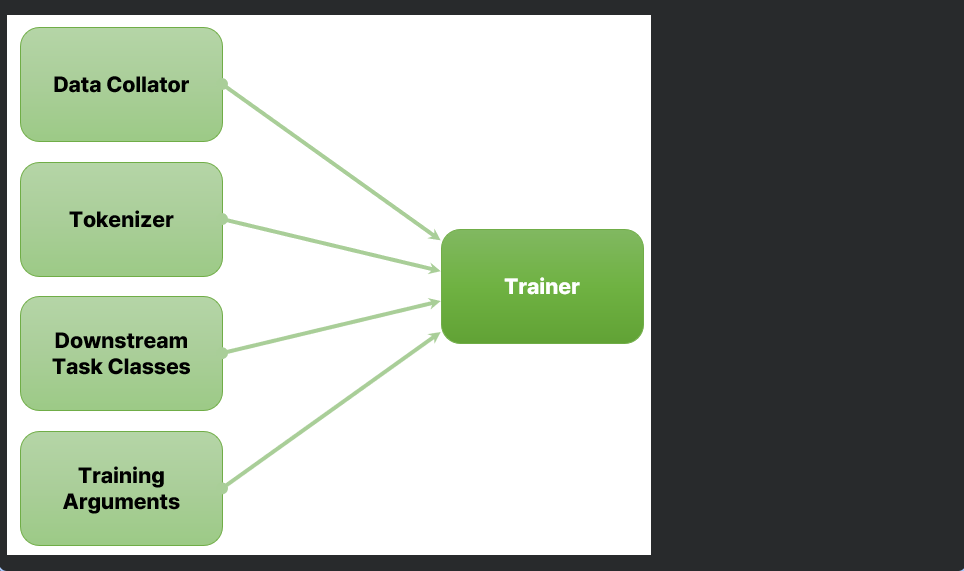

## 2. 토크나이저 로딩
- KoELECTRA 모델로 실습 진행:

#### monologg/koelectra 주요 버전 및 종류

- GitHub : https://github.com/monologg/KoELECTRA/blob/master/README.md

| 모델 이름                                       | 크기    | 역할            | 설명                                                         |
| ------------------------------------------- | ----- | ------------- | ---------------------------------------------------------- |
| `monologg/koelectra-base-generator`         | Base  | Generator     | 토큰 생성기(generator) 역할 · v3 이전 버전         |
| `monologg/koelectra-base-discriminator`     | Base  | Discriminator | 토큰 판별기(discriminator) 역할 · v1/v2 기본 버전  |
| `monologg/koelectra-base-v3-generator`      | Base  | Generator     | v3 버전 · generator                       |
| `monologg/koelectra-base-v3-discriminator`  | Base  | Discriminator | v3 버전 · discriminator                   |
| `monologg/koelectra-small-generator`        | Small | Generator     | 소형 모델 · generator                       |
| `monologg/koelectra-small-discriminator`    | Small | Discriminator | 소형 모델 · discriminator                   |
| `monologg/koelectra-small-v3-generator`     | Small | Generator     | v3 소형 버전 · generator (NSMC 감성분석 등에 활용 가능)                  |
| `monologg/koelectra-small-v3-discriminator` | Small | Discriminator | v3 소형 버전 · discriminator (감정분석, 문장분류 등)                    |
| `monologg/koelectra-small-v3-goemotions`    | Small | Discriminator | v3 소형 버전 · GoEmotions 감정분류용 (영문 감정 레이블 매핑)                 |
| `monologg/koelectra-base-v3-naver-ner`      | Base  | Discriminator | v3 버전 · Naver NER(개체명 인식)용 fine-tuned 모델                   |
| `monologg/koelectra-base-v3-gender-bias`    | Base  | Discriminator | v3 버전 · 성별 편향 분석용 (gender-bias) 모델                         |

In [13]:
# 사전학습 모델 monologg/koelectra-base-v3-discriminator
from transformers import AutoTokenizer
# - 사전 학습된 모델에 맞는 토크나이저를 자동으로 불러오는 기능

In [14]:
model_name = 'monologg/koelectra-base-v3-discriminator'

In [15]:
# 직접 모델 호출
# 토크나이저 다운 받기
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    clean_up_tokenization_spaces = True # 토큰화 후에 공백 문자 등을 정리하는 전처리 옵션 (기본값 True)
)

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [16]:
# 1개 문장을 설정으로 토큰화 테스트해보기
# - 한 개 문장(뉴스제목) 접근
raw_datasets['train'][0]['title']

# tokenizer 기능실행
temp_result = tokenizer(
    raw_datasets['train'][0]['title'],
    truncation = True,
    max_length = 128,
    # return_tensors = 'pt' # 추후에 map()로 토크나이저 호출 시 tensor를 미리 변환하지 않음(error발생)
                            # 보통 Trainer나 DataCollator 사용 시에 배치 텐서형으로 변환하도록 위임할 수 있음
)

temp_result

# input_ids : 토큰 ID 리스트 (정수 시퀀스)
# token_type_ids : 세그먼트 구분ID 리스트 (단일 문장일 경우 모두 0)
# attention_mask : 어텐션 마스크 리스트( 1: 실제 문장 내 토큰 사용, 0: 패딩 )

{'input_ids': [2, 11468, 11642, 22, 4366, 4149, 4200, 32462, 6310, 6800, 6411, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
# 토큰 목록 확인
# 토큰 ID -> 토큰(문자값) : 디코딩
tokenizer.convert_ids_to_tokens(temp_result['input_ids'])

# id: 2, '[CLS]' 문장의 시작점
# id: 3, '[SEP]' 문장의 끝점
# 대부분의 토크나이저는 내부적으로 WordPiece 기반 모델
# 모델이 이해할 수 있도록 문장 -> 서브워드 조각 -> 정수 시퀀스로 변환해줌

['[CLS]',
 '유튜브',
 '내달',
 '2',
 '##일',
 '##까',
 '##지',
 '크리에이터',
 '지원',
 '공간',
 '운영',
 '[SEP]']

In [18]:
# 토크나이저 함수 정의
def tokenizer_function(example):
  # example : 각 뉴스 기사 제목을 가리키는 변수
  return tokenizer(example['title'], truncation = True, max_length = 128)

- 데이터에 토크나이저를 적용하기 위한 함수 종류

> #### **map()**
> - **<U>변환을 즉시 적용**</U>하며, 변환된 결과는 새로운 데이터셋으로 반환됨
> - 토큰화, 라벨 변환 등 데이터 전처리 작업에서 자주 사용

> #### **with_transform()**
> - 변환을 등록해 두고, 실제 **<U>데이터 접근 시 변환을 적용**</U>함 (스트림형)
> - 학습을 수행할 때 호출하여 변형이 이루어짐
> - 메모리 절약을 위해, 또는 데이터셋을 한 번에 모두 변형할 필요가 없을 때 유용

In [19]:
# 데이터셋에 토크나이저 적용 (학습/검증셋 모두 적용)
# DatasetDict - map
tokenized_datasets = raw_datasets.map(
    tokenizer_function, # 데이터셋의 각 예시(또는 배치(문장 여러개))에 적용할 전처리 함수
    batched = True     # True: 예시 하나씩이 아닌, 여러개(배치)씩 모아서 tokenize_func에 전달
                       # 속도 향상(벡터화된 연산), 'padding'+'truncation' 옵션 적용시 일괄 처리에 적합
)
tokenized_datasets

# 'input_ids', 'token_type_ids', 'attention_mask' 새로운 필드(속성)가 추가됨을 확인

Map:   0%|          | 0/45678 [00:00<?, ? examples/s]

Map:   0%|          | 0/9107 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9107
    })
})

In [20]:
# features 확인
print(tokenized_datasets['train'].features)
print(tokenized_datasets['train'])

{'guid': Value('string'), 'title': Value('string'), 'label': ClassLabel(names=['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']), 'url': Value('string'), 'date': Value('string'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}
Dataset({
    features: ['guid', 'title', 'label', 'url', 'date', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 45678
})


In [21]:
# 원본에서 불필요한 삭제용 컬럼명 추출
# label은 학습 시에 필요하므로 제외
remove_columns = [key for key in raw_datasets['train'].features.keys() if key != 'label']
remove_columns

# 전처리 데이터가 아닌, 원본 feature 값에서 label을 제외한 나머지 컬럼명만 선택 -> 삭제 예정

['guid', 'title', 'url', 'date']

In [22]:
# 훈련에 필요하지 않은 컬럼(feature, 필드) 제거 및 업데이트
# DatasetDict 내장된 삭제 함수 활용 : remove_columns()
tokenized_datasets = tokenized_datasets.remove_columns(remove_columns) # 전처리 데이터셋 초기화

In [23]:
tokenized_datasets

# ['input_ids', 'token_type_ids', 'attention_mask'] 훈련에 필요한 입력과 'label'만 남은 상황

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45678
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9107
    })
})

### 3. 모델 불러오기
- 다운스트림 task class 로드 (사전학습 모델 불러오기)
- 해석하기 쉽게 모델 설정에서 레이블 이름도 등록해주자.

In [24]:
# 이미 label 컬럼의 메타 정보로 클래스 이름이 들어있는 상황
# 레이블명 추출 (인덱스 순서대로 레이블 이름 리스트 반환)
label_names = tokenized_datasets['train'].features['label'].names

In [25]:
label_names

['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']

In [26]:
# id2label = {0:IT과학', 1:'경제', ...}
# label2id = {IT과학','경제', ...}
# 예측값에 대해 해석하기 쉽게 모델에 반영하기 위함

id2label = {i:name for i, name in enumerate(label_names)}
id2label
label2id = {name:i for i, name in enumerate(label_names)}
print(id2label)
print(label2id)

{0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}
{'IT과학': 0, '경제': 1, '사회': 2, '생활문화': 3, '세계': 4, '스포츠': 5, '정치': 6}


In [27]:
# 모델 불러오는 클래스 연결
from transformers import AutoModelForSequenceClassification # 분류

In [28]:
# 사전 학습 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, # monologg/koelectra-base-v3-discriminator
    num_labels = len(label_names) # 분류할 라벨의 클래스 수(7개) 설정
)

# 안내문이 출력됨
# fine-tuning 과정을 거쳐야 하는 분류 헤드가 제대로 학습되어 예측, 추론이 가능하다는 안내

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# 모델 설정 - 라벨 이름 확인
print(label_names)
print(model.config.id2label)
print(model.config.label2id)

# 직접 생성해둔 dict 아이디 관련 정보 연결
print(id2label)
print(label2id)
# 모델 설정에 라벨 이름 매핑하여 업데이트.
model.config.id2label = id2label
model.config.label2id = label2id

['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치']
{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6'}
{'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2, 'LABEL_3': 3, 'LABEL_4': 4, 'LABEL_5': 5, 'LABEL_6': 6}
{0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}
{'IT과학': 0, '경제': 1, '사회': 2, '생활문화': 3, '세계': 4, '스포츠': 5, '정치': 6}


In [30]:
# 업데이트 확인
print(model.config.id2label)
print(model.config.label2id)

{0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}
{'IT과학': 0, '경제': 1, '사회': 2, '생활문화': 3, '세계': 4, '스포츠': 5, '정치': 6}


## 4. Data Collator & 평가지표 함수 정의
> Collator
> - Trainer에게 데이터를 전달해주는 클래스
> - 이때, 트랜스포머 모델 입력은 길이가 다를 수 있는 시퀀스므로, 한 배치 내 최대 길이에 맞추어 패딩이 필요

> 평가지표 함수
> - 학습 중 검증 단계에서 계산할 평가지표 함수 정의
> - 정확도, 정밀도, 재현율, F1스코어 활용해보기

In [31]:
from transformers import DataCollatorWithPadding
# 동적 배치 기능(유틸리티), 문장 내 최대 길이(128)에 맞춰 패딩하여 Trainer에게 전달해주는 클래스

In [32]:
# tokenizer 인식 하도록 설정
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)
# 토큰화하는데 사용된 토크나이저 지정

In [33]:
# tokenizer 지정 이융
# - 해당 도구가 가지고 있는
# - pad_token_id (패딩 토큰 번호)
# - padding_side(패딩을 어느쪽에 채우는지)
# - model_max_length(최대 입력 길이) 등
# 패딩 기준 정보 제공하기 위함

#### 평가지표 함수 정의
- 실제 훈련에 적용하기 전에 validation set을 활용하여 test

- 1. 예측에 사용할 모델 입력 만들기

In [34]:
model = model.to(device)

In [35]:
# 검증셋에서 샘플 가져오기
sample = tokenized_datasets['validation'][0]
print(sample)

{'label': 2, 'input_ids': [2, 25, 4639, 4005, 23362, 18075, 4034, 2411, 4219, 27, 4156, 4172, 4005, 6874, 4164, 4034, 3081, 4880, 4176, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [36]:
# 모델에 입력으로 전달하기 위해 변환 작업 필요
# 사용할 필드(label 제외)만 뽑아서 Tensor변환 후 gpu로 이동할 예정

# use_columns = [key for key in tokenized_datasets['validation'].features.keys()]
# use_columns = use_columns[1:]
# use_columns

# 조건문
use_columns = [key for key in tokenized_datasets['validation'].features.keys() if key != 'label']
use_columns

['input_ids', 'token_type_ids', 'attention_mask']

In [37]:
# 1. 처리된 모델 입력값 담아둘 딕셔너리 초기화
inputs = {}

# 2. sample 순회
for key, value in sample.items():
  # 3. 사용할 필드 (use_columns) 확인
  if key in use_columns:
    tensor = torch.tensor(value) # 파이토치 텐서로 변환 -> transformer 모델 입력은 tensor 처리 가능
    tensor = tensor.unsqueeze(0) # 차원추가 (예시: [seq_len]-> [1, seq_len] ) -> 모델 배치 단위 입력에 맞춰 변환
    tensor = tensor.to(device) # 앞서 확인한 device(gpu)로 이동 -> tensor를 gpu로 이동시켜,
                               # gpu의 가속을 활용하여 추론 속도를 높임
                               # + 모델 자체도 현재 gpu에 있는 상황

    # 딕셔너리 추가
    inputs[key] = tensor

inputs

{'input_ids': tensor([[    2,    25,  4639,  4005, 23362, 18075,  4034,  2411,  4219,    27,
           4156,  4172,  4005,  6874,  4164,  4034,  3081,  4880,  4176,     3]],
        device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
        device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')}

In [38]:
# 정답레이블 같은 방식으로 Tensor형태로 변환 후 gpu 이동
labels = sample['label']
labels_tensor = torch.tensor([labels]) # [2] 모양의 tensor 생성
labels_tensor = labels_tensor.to(device)
labels_tensor

tensor([2], device='cuda:0')

In [39]:
# 학습 직접x
# sample 기준으로 추론(예측) -> 평가지표 활용 확인
# 학습과정을 중단(gradient 기울 계산중단)

with torch.no_grad(): # 기울기 계산 끄기
  # 예측
  outputs = model(**inputs) # 모델의 입력값을 dict 변환하여 예측 모델에 연결

In [43]:
# 예측 결과인 logits값을 cpu로 가지고 온 후 넘파이 배열로 변환함

logits = outputs.logits.cpu().numpy()
logits

array([[ 0.08067246,  0.00446174, -0.02823162, -0.08290139, -0.01220636,
        -0.00769626,  0.06321328]], dtype=float32)

- 2. 평가지표 활용

In [41]:
# 평가지표로는 sklearn 활용
# sklearn metrics는 cpu 메모리 사용 및 numpy 배열 선호
import numpy as np

In [48]:
# 예측 vs 실제 비교
pred = np.argmax(logits) # 최대값 인덱스(=예측 라벨) 추측
pred
print("pred", pred, "->", model.config.id2label[pred])
print('actual:', labels, "->", model.config.id2label[labels])

pred 0 -> IT과학
actual: 2 -> 사회


In [49]:
# 평가지표 불러오기
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# precision_recall_fscore_support: 정밀도/재현율/f1-score/샘플개수를 한번에 표현해주는 기능

In [50]:
# logits -> cpu, numpy
labels = labels_tensor.cpu().numpy()
labels

array([2])

In [51]:
# 단일 예측값 1차원 array 배열로 변환
preds = np.array([pred])
preds

array([0])

In [52]:
# 정확도를 측정해보자
acc = accuracy_score(labels, preds)
acc

0.0

In [53]:
# 정밀도, 재현율, f1-score 계산
# -- 0
prec, rec, f1, _ = precision_recall_fscore_support(
    # _: 의미 없는 값을 담을 변수, support(각 클래스별 표본 수)
    labels,
    preds,
    average = 'macro', # 각 클래스별 결과를 계산한 뒤, 모든 클래스를 동일한 비중으로 평균을 내도록
    zero_division = 0  # 분모가 0이 되는 경우 결과를 0으로 처리
)

prec, rec, f1, _

(0.0, 0.0, 0.0, None)

### Trainer에게 전달할 평가지표 함수 정의

In [54]:
def compute_metrics(eval_pred):
  """
  Trainer가 사용하는 평가지표 함수
  - eval_pred: (logits, labels) 튜플
  """

  logits, labels = eval_pred # unpacking: 튜플로 묶인 2개요소를 각각 하나의 변수로 대입
  preds = np.argmax(logits, axis = 1) # axis = 1, 열방향으로 데이터를 비교하면서 최대값이 있는 인덱스 반환

  # 정확도
  acc = accuracy_score(labels, preds)

  # 정밀도, 재현율, f1(macro average)
  prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average = 'macro')
  return {"accuracy":acc, "precision":prec, "recall":rec, "f1": f1}

In [55]:
# 모델이 한번의 학습(훈련) 과정에서 처리할 데이터 수 정의
batch_size = 64

# 배치 크기가 크면, 더 많은 데이터를 한번에 처리할 수 있으므로 업데이트 회수는 줄지만, 메모리 사용량 증가
# 배치 크기가 작으면, 더 자주 업데이트함, 하나의 배치에서 계산된 손실이 불안정할 수 있음, 메모리 사용량 감소

## 5.Training Arguments 설정

In [56]:
from transformers import TrainingArguments

In [57]:
# 학습에 필요한 하이퍼파라미터 및 설정
training_args = TrainingArguments(
    output_dir = './data/ynay-model',     # 학습 결과(모델 가중치, 체크포인트 등)을 저장할 디렉토리
    num_train_epochs = 3,                   # 학습할 에포크(Epoch) 수, 전체 데이터셋을 몇 번 반복하여 학습할지를 설정함
    per_device_train_batch_size = batch_size, # 학습 시 사용될 배치 크기
    per_device_eval_batch_size = batch_size,  # 검증 시 배치 크기
    learning_rate = 5e-5,                    # 학습률 (5e-5=0.00005 : BERT계열 모델에 흔히 쓰이는 값)
    eval_strategy = 'epoch',                 # 이벨류에이션 스트레이트지(검증 전략), "epoch"로 하면 각 epoch 끝날 때 검증
    logging_steps = 50,                       # 학습 중간에 로그를 찍는 간격 (스텝 수)
    save_strategy = 'epoch',                  # 모델 저장 전략 (여기서는 epoch마다 저장)
    load_best_model_at_end = True,          # True : 검증 성능이 최고인 체크포인트를 마지막에 불러옴
    metric_for_best_model = "accuracy",      # 최고 모델 판단에 사용할 메트릭 ("accuracy"으로 지정)
    push_to_hub = False,                    # 학습 후 수동으로 push 예정
    report_to = 'none'                   # W&B 비활성화 (W&B 연동 시, 로그를 남기기 위해 API 키 인증을 요구하므로 none 설정)
                                              # 24년 10월 경부터 Trainer에 기본값으로 W&B(Weights & Biases)에 실험(run)을 기록하도록 설정되어 있음
)

## 6. Trainer 초기화 & Fine-Tuning(미세조정)
- Trainer 클래스: 모델 훈련을 간소화해주는 고수준 API
- Training Arguments, 모델, 데이터셋, 데이터 콜레터, 평가함수 등을 인자로 받아 내부에서 학습 루프를 관리하는 유틸리티

In [58]:
from transformers import Trainer

In [59]:
# 학습 객체 생성
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['validation'],
    data_collator = data_collator,
    processing_class = tokenizer,
    compute_metrics = compute_metrics # 평가지표
)

In [60]:
# 학습 - 미세조정하며 학습 진행
# t4 gpu -
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.390200,0.477671,0.833974,0.809195,0.872512,0.836402
2,0.297400,0.396020,0.856594,0.847529,0.869116,0.857145
3,0.215900,0.410736,0.861755,0.852777,0.873568,0.862704


TrainOutput(global_step=2142, training_loss=0.36423377518782984, metrics={'train_runtime': 175.6898, 'train_samples_per_second': 779.977, 'train_steps_per_second': 12.192, 'total_flos': 1616745095802300.0, 'train_loss': 0.36423377518782984, 'epoch': 3.0})

## 7.모델평가 및 성능 분석
- 검증 데이터에 대한 최종 성능을 확인과 함께 혼돈행렬표 관측
- trainer.predict로 개별 예측도 진행

In [61]:
# 검증 셋에 대한 최종 평가
metrics = trainer.evaluate()
metrics

{'eval_loss': 0.4107363522052765,
 'eval_accuracy': 0.8617546941912815,
 'eval_precision': 0.8527771045397683,
 'eval_recall': 0.8735683471729799,
 'eval_f1': 0.8627038858868571,
 'eval_runtime': 3.7973,
 'eval_samples_per_second': 2398.306,
 'eval_steps_per_second': 37.659,
 'epoch': 3.0}

- 혼동행렬표를 통해 어떤 주제에서 오분류가 발생하는지 관측

In [62]:
# 혼동행렬표
from sklearn.metrics import confusion_matrix

In [63]:
# 검증셋으로 예측값 확인
pred_results = trainer.predict(tokenized_datasets['validation'])
pred_results

# PredictionOutput 객체
# - predictions: 모델의 raw logits 배열 (샘플의 개수 x 라벨의 수) --> 예측
# - label_ids: 실제 레이블 배열 --> 실제
# - metrics : 평가 지표 포함

PredictionOutput(predictions=array([[-0.7715609 ,  5.3841767 ,  1.8035575 , ..., -2.8630373 ,
        -1.7829418 , -1.877169  ],
       [ 1.6628416 , -0.24003378,  4.6036716 , ..., -2.853071  ,
        -3.1170726 , -0.685634  ],
       [ 5.39956   , -0.03892947, -0.09687607, ..., -1.3114855 ,
        -2.0351763 , -2.8670163 ],
       ...,
       [-1.2217255 ,  5.821796  ,  1.7212732 , ..., -2.4545848 ,
        -1.9767869 , -2.0046198 ],
       [-1.9337186 , -1.8211256 ,  4.94402   , ..., -2.9507608 ,
        -1.8608712 ,  0.5489576 ],
       [-0.19380936, -1.1219031 ,  5.1004705 , ..., -2.9671438 ,
        -2.443972  , -1.4204676 ]], dtype=float32), label_ids=array([2, 2, 0, ..., 1, 2, 2]), metrics={'test_loss': 0.4107363522052765, 'test_accuracy': 0.8617546941912815, 'test_precision': 0.8527771045397683, 'test_recall': 0.8735683471729799, 'test_f1': 0.8627038858868571, 'test_runtime': 3.9519, 'test_samples_per_second': 2304.461, 'test_steps_per_second': 36.185})

In [64]:
# y_true, y_pred
y_true = pred_results.label_ids
y_true

y_pred = np.argmax(pred_results.predictions, axis = 1) # 각 행의 값에서 가장 큰 값의 위치를 반환하도록 설정
y_pred

array([1, 2, 0, ..., 1, 2, 2])

In [65]:
# 혼동행렬표
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 452,   22,   59,    9,    8,    4,    0],
       [  31, 1172,  118,    9,   13,    4,    1],
       [  75,  217, 3105,  143,   40,   14,  107],
       [  16,   18,  108, 1197,   16,   10,    4],
       [   7,   12,   18,   24,  745,   18,   11],
       [   0,    1,    8,    3,    4,  562,    0],
       [   0,    3,   80,    4,   16,    4,  615]])

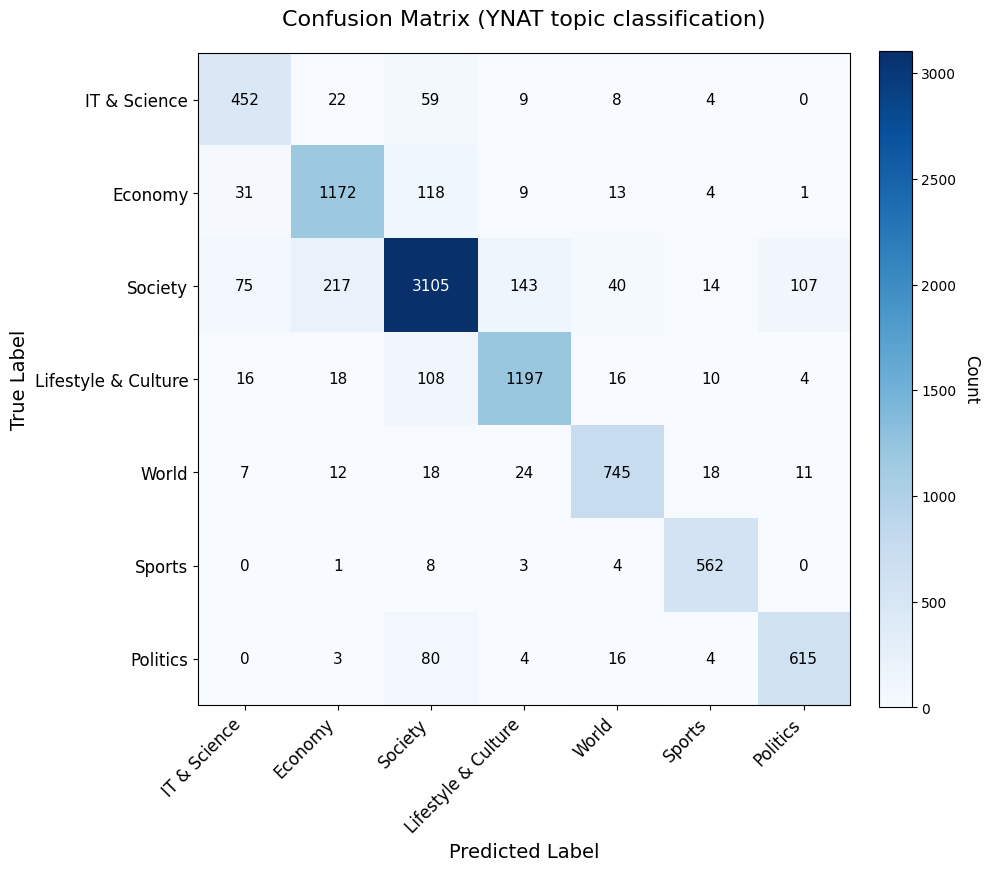

In [69]:
import matplotlib.pyplot as plt

# plt.rc('font', family = "./data/GULIM.TTC")      # 기본 폰트로 Gulim 지정
# plt.rc('axes', unicode_minus = False) # 마이너스 기호가 깨지지 않도록 설정
# 레이블 이름 리스트 생성
label_names = ['IT & Science', 'Economy', 'Society', 'Lifestyle & Culture', 'World', 'Sports', 'Politics']
label_names
# Figure & Axes(그래프 그릴 영역) 생성
fig, ax = plt.subplots(figsize=(10, 10)) # 전체 그림 크기를 10×10인치로 지정

# 혼동행렬 시각화
# ax.imshow: 2D 배열(혼돈행렬)을 컬러맵으로 시각화
im = ax.imshow(cm, cmap='Blues') # 파란색 계열 색상표 사용

# 컬러바 추가
cbar = fig.colorbar(
    im,               # 시각화된 이미지 객체
    ax = ax,          # 컬러바를 붙일 Axes 지정
    fraction = 0.046, # 컬러바 너비 조절
    pad = 0.04        # 컬러바 간격 조절
)

# 컬러바 축의 레이블 설정
cbar.ax.set_ylabel(
    'Count',        # 레이블 텍스트
    rotation = -90, # 레이블 세로 방향으로 회전
    va = "bottom",  # 수직 정렬을 아래쪽으로
    fontsize = 12   # 글자 크기
)

# 눈금 위치 및 레이블 설정
n = len(label_names)                # 레이블 개수
ax.set_xticks(np.arange(n)) # 눈금(tick) 위치를 0..n-1로 지정
ax.set_yticks(np.arange(n)) # 눈금(tick) 위치를 0..n-1로 지정

# 눈금에 표시할 텍스트 지정
ax.set_xticklabels(label_names, rotation = 45, ha = "right", fontsize = 12) # X축 레이블 45도 회전, 수평 정렬을 오른쪽으로, 글자 크기 12
ax.set_yticklabels(label_names, fontsize = 12)

# 축 제목 및 메인 타이틀
ax.set_xlabel("Predicted Label", fontsize=14)
ax.set_ylabel("True Label", fontsize=14)
ax.set_title("Confusion Matrix (YNAT topic classification)", fontsize = 16, pad = 20) # 전체 그래프 제목 설정
                                                                                      # pad : 제목과 그래프 사이 여백(px)

# 각 셀에 값 표시
threshold = cm.max() / 2                                     # 셀 색 대비가 어두운지 밝은지 판단 기준
for i in range(n):
    for j in range(n):
        color = "white" if cm[i, j] > threshold else "black" # 셀 값이 threshold 이상이면 흰색 텍스트, 아니면 검정색
        ax.text(j, i, cm[i, j], ha = "center", va = "center", color = color, fontsize = 11) # ha, va: 수평·수직 정렬 방식

# 레이아웃 자동 조정 & 출력
plt.tight_layout() # 여백을 자동으로 조절해 레이블 겹침 방지
plt.show()

In [70]:
# 전반적성능
# - eval_accuracy : 90%, 전체 샘플 중 약 90%를 올바르게 분류
# 히트맵 그래프 확인
# - 클래스별 정확도 (대각선의 샘플)
# - 대부분 대각선에 분포가 된 것을 확인
# - 다만, 경제와 사회 분야 헤드라인(뉴스제목)은 구분 모호한 경우도 있는 편
# - 생활/문화 헤드라인은 대체적으로 폭넓은 내용을 담고 있어서, 다양한 분류로 오분류가 된 상황
# - 각각의 카테고리를 구분할 수 있는 핵심 주제어와 맥락을 연결하여서 좋은 데이터셋으로 학습 해봐도 좋을 듯함

## 8. HuggingFace 허브에 모델 업로드하기
- 생성된 모델을 각자의 profile 업로드를 해볼 예정
- huggingface 로그인이 필요

In [71]:
# Command Line을 통해 로그인 명령 실행
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `ESTCampAI` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credentia

In [72]:
# Hugging Face Hub에 업로드할 때 함께 전달할 메타데이터 정보
kwargs = {
    "finetuned_from": model.config._name_or_path, # 이번에 파인튜닝에 활용한 사전학습 모델 이름/경로
    "tasks": ["text-classification"],             # 이 모델이 수행하는 태스크 종류(여러 개일 경우 리스트로)
    "dataset": ["klue-ynat"],                     # 학습·평가에 사용된 데이터셋 이름
    "tags": [                                     # 모델을 설명하는 태그들 (모델 검색 시 키워드 역할)
        "text-classification",
        "KoELECTRA",
        "Korean-NLP",
        "topic-classification",
        "news-classification"
    ],
    "language": ["ko"],                           # 모델이 지원하는 언어 (ISO 코드)
}

In [73]:
# 수동으로 trainer.push_to_hub()을 호출하여 업로드할 수 있음
trainer.push_to_hub('ESTCampAI/news-classifier', **kwargs)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...y-model/model.safetensors:   0%|          |  570kB /  452MB            

  ...y-model/training_args.bin:   1%|1         |  65.0B / 5.84kB            

CommitInfo(commit_url='https://huggingface.co/good0neighbour/ynay-model/commit/7e07b0a86c79798386d5b7a01f3299ddf4281448', commit_message='ESTCampAI/news-classifier', commit_description='', oid='7e07b0a86c79798386d5b7a01f3299ddf4281448', pr_url=None, repo_url=RepoUrl('https://huggingface.co/good0neighbour/ynay-model', endpoint='https://huggingface.co', repo_type='model', repo_id='good0neighbour/ynay-model'), pr_revision=None, pr_num=None)